In [1]:
import math
import random
from collections.abc import Callable
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('city.csv')

In [2]:
df.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [3]:
df = df.sort_values(by='population', ascending=False).iloc[:30]

In [4]:
def distance(city1: pd.Series, city2: pd.Series) -> float:
    """
    Calculate the distance between two cities in km

    Args:
        city1: pd.Series - the first city, should contain contrain columns 
        "geo_lat" and "geo_lon" corresponding to latitude and longitude
        city2: pd.Series - the second city, should contain contrain columns 
        "geo_lat" and "geo_lon" corresponding to latitude and longitude
    
    Returns:
        The distance between two cities in km
    """
    lat1, lon1 = city1['geo_lat'], city1['geo_lon']
    lat2, lon2 = city2['geo_lat'], city2['geo_lon']
    radius = 6371  # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

In [5]:
def objective_function(df: pd.DataFrame, path: list[int]) -> float:
    """
    calculate the objective function, i.e. the total path distance

    Args:
        df: pd.DataFrame - dataframed containing the information about cities, 
        should contain contrain columns "geo_lat" and "geo_lon" corresponding to 
        latitude and longitude
        path: list[int] - current path, list with indexes of cities in the path
    """
    total_distance = 0
    for i in range(len(path)-1):
        total_distance += distance(df.iloc[path[i]], df.iloc[path[i+1]])

    total_distance += distance(df.iloc[path[-1]], df.iloc[path[0]]) # add distance back to the starting point
    return total_distance

In [6]:
def simulated_annealing(path: list[int], 
                        objective_function: Callable[[pd.DataFrame, list[int]], 
                                                     float], 
                        initial_temperature: float, 
                        cooling_rate: float, 
                        stopping_temperature: float
                        ) -> tuple[list[list[int]], list[float]]:
    """
    Simulated annealing algorithm

    Args:
        path: list[int] - initial path, list of indexes of cities
        objective_function: Callable[[pd.DataFrame, list[int]], float] - 
                            objective function to be optimized
        initial_temperature: float - initial temperature of the algorithm
        cooling_rate: float - rate determining how fast the system will cooled 
                      dowm
        stopping_temperature: float - temperature at which the algorithm will 
                              stop
    
    Returns:
        list[list[int]] - the resulting path after each iteration
        list[float] - the value of objective function at each iteration
    """
    temperature = initial_temperature
    current_path = path.copy()
    current_objective = objective_function(df, current_path)
    results = [current_objective]
    paths = [current_path]
    while temperature > stopping_temperature:
        next_path = current_path.copy()
        # swap two random cities to get the next path
        i, j = random.sample(range(len(next_path)), 2)
        next_path[i], next_path[j] = next_path[j], next_path[i]
        next_objective = objective_function(df, next_path)
        # check whether to accept new proposed path or not
        delta = next_objective - current_objective
        if random.random() <= np.exp(-delta/temperature):
            current_path = next_path
            current_objective = next_objective
        # reduce temperature
        temperature *= cooling_rate
        results.append(current_objective)
        paths.append(current_path)
    return paths, results

In [7]:
# Define the initial path as the order of the cities in the dataset
initial_path = list(range(len(df)))

# Set the parameters for the simulated annealing algorithm
initial_temperature = 2500
cooling_rate_slow = 0.99
cooling_rate_medium = 0.95
cooling_rate_fast = 0.9
stopping_temperature = 20

start = time.time()
results_fast = []
for i in range(10):
    best_path_fast, results_current_fast = \
    simulated_annealing(initial_path, objective_function, initial_temperature, 
                        cooling_rate_fast, stopping_temperature)
    results_fast.append(results_current_fast)
results_fast = np.array(results_fast).mean(axis=0)
end = time.time()
print(f"Fast cooling: Best objective = {results_fast[-1]}, time = {end-start}")

start = time.time()
results_medium = []
for i in range(10):
    best_path_medium, results_current_medium = \
    simulated_annealing(initial_path, objective_function, initial_temperature, 
                        cooling_rate_medium, stopping_temperature)
    results_medium.append(results_current_medium)
results_medium = np.array(results_medium).mean(axis=0)
end = time.time()
print(f"Fast cooling: Best objective = {results_medium[-1]}, time = {end-start}")

start = time.time()
results_slow = []
for i in range(10):
    best_path_slow, results_current_slow = \
    simulated_annealing(initial_path, objective_function, initial_temperature, 
                        cooling_rate_slow, stopping_temperature)
    results_slow.append(results_current_slow)
results_slow = np.array(results_slow).mean(axis=0)
end = time.time()
print(f"Fast cooling: Best objective = {results_slow[-1]}, time = {end-start}")

Fast cooling: Best objective = 44875.20466927851, time = 2.9346923828125
Fast cooling: Best objective = 37166.716583645175, time = 16.67081332206726
Fast cooling: Best objective = 26726.07031776567, time = 34.2965190410614


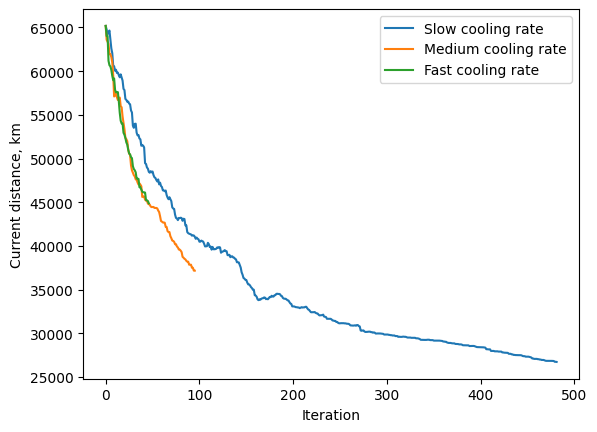

In [8]:
plt.plot(results_slow)
plt.plot(results_medium)
plt.plot(results_fast)
plt.xlabel("Iteration")
plt.ylabel("Current distance, km")
plt.legend(["Slow cooling rate", "Medium cooling rate", "Fast cooling rate"])

In [9]:
cities_slow = [[df.iloc[i]["address"] for i in path] for path in best_path_slow]
cities_medium = [[df.iloc[i]["address"] for i in path] for path in best_path_medium]
cities_fast = [[df.iloc[i]["address"] for i in path] for path in best_path_fast]

In [10]:
from matplotlib.animation import FuncAnimation
import networkx as nx
from functools import partial

def update(frame, cities, best_path, ax):
    ax.clear() 
    A = np.zeros((30, 30))
    G = nx.DiGraph()
    for i in range(len(cities[frame])):
        orig_idx = best_path[frame][i]
        G.add_node(cities[frame][i], pos=(df.iloc[orig_idx]["geo_lon"], 
                                        df.iloc[orig_idx]["geo_lat"]))

    for i in range(len(cities[frame])):
        if i != len(cities[frame]) - 1:
            G.add_edge(cities[frame][i], cities[frame][i+1])
        else:
            G.add_edge(cities[frame][i], cities[frame][0])

    G.remove_edges_from(nx.selfloop_edges(G))
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos, with_labels=True, ax=ax)

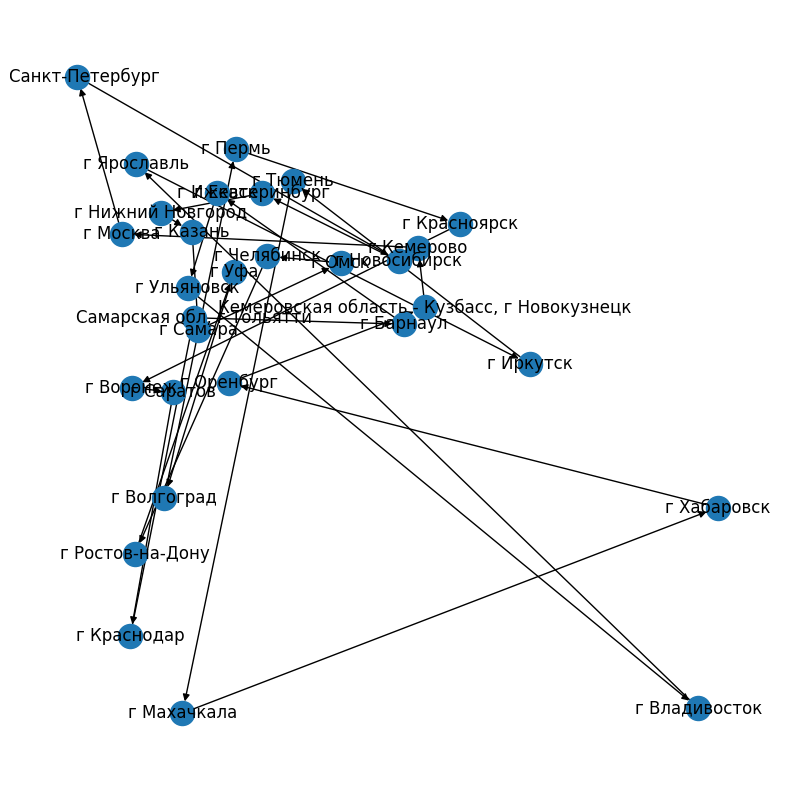

In [11]:
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(10,10))
ani = FuncAnimation(fig, partial(update, cities=cities_fast, 
                                 best_path=best_path_fast, ax=ax), 
                    frames=len(cities_fast), interval=100)
HTML(ani.to_html5_video())

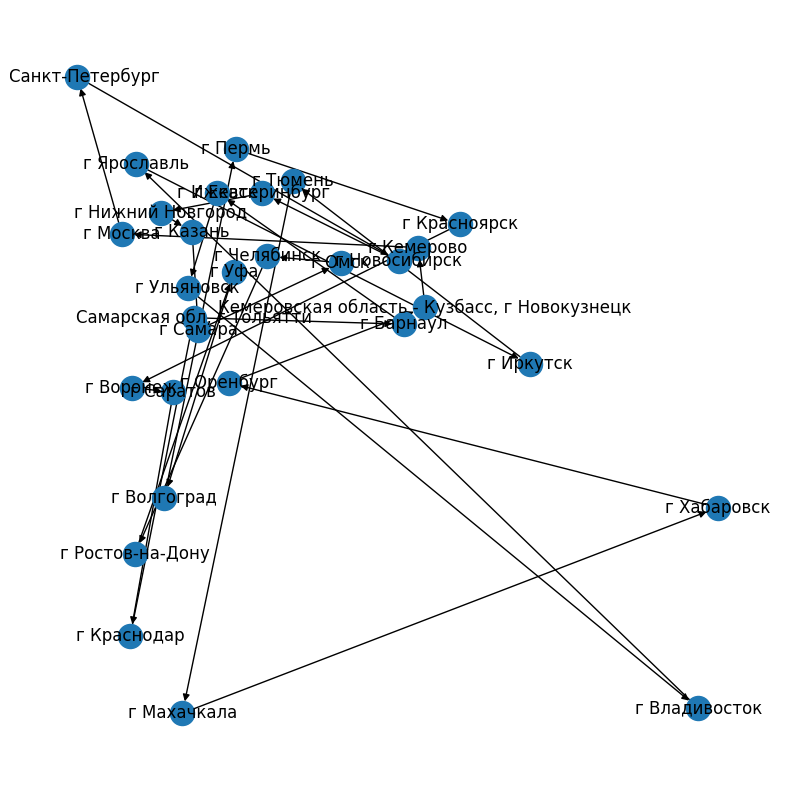

In [12]:
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(10,10))
ani = FuncAnimation(fig, partial(update, cities=cities_medium, 
                                 best_path=best_path_medium, ax=ax), 
                    frames=len(cities_medium), interval=100)
HTML(ani.to_html5_video())

In [13]:
from IPython.display import HTML
ani = FuncAnimation(fig, partial(update, cities=cities_slow, 
                                 best_path=best_path_slow, ax=ax), 
                    frames=len(cities_slow), interval=100)
HTML(ani.to_html5_video())